# Data importing, cleaning and preparation

## Import all the packages needed for the analysis 

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import config as cf

## Energy access, consumption, output and efficiency
- access_to_electricity_(%_of_total_population)
- energy_intensity_level_of_primary_energy_(mj/2011_usd_ppp)
- total_electricity_output_(gwh)
- total_final_energy_consumption_(tfec)_(tj)

In [5]:
energy = pd.read_csv('./data/energy_data.csv')
energy.columns = [col.lower() for col in energy.columns]
energy.columns = [col.replace(' ', '_') for col in energy.columns]
energy.drop(columns=['time_code'], inplace=True)
energy = energy[:-5]
energy = energy.rename(columns={'country_name': 'country', 'time':'year', 'access_to_electricity_(%_of_total_population)_':'access_electricity_%', 'energy_intensity_level_of_primary_energy_(mj/2011_usd_ppp)':'energy_intensity', 'total_electricity_output_(gwh)':'total_output', 'total_final_energy_consumption_(tfec)_(tj)': 'total_consumption'})
energy['year'] = pd.to_datetime(energy['year'], format='%Y').dt.strftime('%Y-%m-%d')
energy[['access_electricity_%', 'energy_intensity', 'total_output', 'total_consumption']] = energy[['access_electricity_%', 'energy_intensity', 'total_output', 'total_consumption']].replace('..', np.nan) # Replace empty strings with NaN
energy[['access_electricity_%', 'energy_intensity', 'total_output', 'total_consumption']] = energy[['access_electricity_%', 'energy_intensity', 'total_output', 'total_consumption']].astype(float) # Convert the column to float
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4403 entries, 0 to 4402
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               4403 non-null   object 
 1   country_code          4403 non-null   object 
 2   year                  4403 non-null   object 
 3   access_electricity_%  3675 non-null   float64
 4   energy_intensity      3066 non-null   float64
 5   total_output          3647 non-null   float64
 6   total_consumption     3716 non-null   float64
dtypes: float64(4), object(3)
memory usage: 240.9+ KB


## Electricity generation (GWh) and capacity (MW) of renewable energy

In [6]:
re_capacity = pd.read_csv('./data/re_capacity_by_country.csv', encoding='latin1',header=1).reset_index()
re_capacity.columns = [col.lower() for col in re_capacity.columns]
re_capacity.columns = [col.replace(' ', '_') for col in re_capacity.columns]
re_capacity.drop(columns=['index','grid_connection', 'data_type'], inplace=True)
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('wind'), 'technology'] = 'Wind'
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('biofuels'), 'technology'] = 'Biofuels'
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('geothermal'), 'technology'] = 'Geothermal'
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('hydropower|mixed hydro plants'), 'technology'] = 'Hydropower'
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('solar'), 'technology'] = 'Solar'
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('biogas'), 'technology'] = 'Biofuels'
re_capacity.loc[re_capacity['technology'].str.lower().str.contains('marine energy|renewable municipal waste'), 'technology'] = 'Others'
re_capacity = re_capacity.rename(columns={'country/area': 'country', 'electricity_statistics':'electricity_capacity_mw', 'technology':'type'})
re_capacity= re_capacity.groupby(['country', 'type', 'year']).agg({'electricity_capacity_mw':'sum'}).reset_index()
re_capacity = re_capacity[re_capacity['type'] != 'total_investments']
re_capacity.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37632 entries, 0 to 37631
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  37632 non-null  object 
 1   type                     37632 non-null  object 
 2   year                     37632 non-null  int64  
 3   electricity_capacity_mw  37632 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
re_generation = pd.read_csv('./data/re_generation_by_country.csv', encoding='latin1', header=1).reset_index()
re_generation.columns = [col.lower() for col in re_generation.columns]
re_generation.columns = [col.replace(' ', '_') for col in re_generation.columns]
re_generation.drop(columns=['index','grid_connection', 'data_type'], inplace=True)
re_generation.loc[re_generation['technology'].str.lower().str.contains('wind'), 'technology'] = 'Wind'
re_generation.loc[re_generation['technology'].str.lower().str.contains('biofuels'), 'technology'] = 'Biofuels'
re_generation.loc[re_generation['technology'].str.lower().str.contains('geothermal'), 'technology'] = 'Geothermal'
re_generation.loc[re_generation['technology'].str.lower().str.contains('hydropower|mixed hydro plants'), 'technology'] = 'Hydropower'
re_generation.loc[re_generation['technology'].str.lower().str.contains('solar'), 'technology'] = 'Solar'
re_generation.loc[re_generation['technology'].str.lower().str.contains('biogas'), 'technology'] = 'Biofuels'
re_generation.loc[re_generation['technology'].str.lower().str.contains('marine energy|renewable municipal waste'), 'technology'] = 'Others'
re_generation = re_generation.rename(columns={'country/area': 'country', 'electricity_statistics':'electricity_generation_gwh', 'technology':'type'})
re_generation = re_generation.groupby(['country', 'type', 'year']).agg({'electricity_generation_gwh':'sum'}).reset_index()
re_generation = re_generation[re_generation['type'] != 'total_investments']
re_generation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37632 entries, 0 to 37631
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     37632 non-null  object 
 1   type                        37632 non-null  object 
 2   year                        37632 non-null  int64  
 3   electricity_generation_gwh  37632 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.4+ MB


## Merging re_capacity and re_generation to renewable_energy

In [8]:
renewable_energy = re_capacity.merge(re_generation, how='outer', on=['country', 'type', 'year'])
renewable_energy[renewable_energy['type'] == 'Wind']

,country,type,year,electricity_capacity_mw,electricity_generation_gwh
144,Afghanistan,Wind,2000,0.0,0.0
145,Afghanistan,Wind,2001,0.0,0.0
146,Afghanistan,Wind,2002,0.0,0.0
147,Afghanistan,Wind,2003,0.0,0.0
148,Afghanistan,Wind,2004,0.0,0.0
...,...,...,...,...,...
37627,Zimbabwe,Wind,2019,0.0,0.0
37628,Zimbabwe,Wind,2020,0.0,0.0
37629,Zimbabwe,Wind,2021,0.0,0.0
37630,Zimbabwe,Wind,2022,0.0,0.0


## Share of renewable energy generation and capacity 

In [9]:
re_share = pd.read_csv('./data/re_share_by_country.csv', delimiter=',', encoding='latin1', header=1)
re_share.columns = [col.lower() for col in re_share.columns]
re_share.columns = [col.replace(' ', '_') for col in re_share.columns]
re_share = re_share.rename(columns={'region/country/area': 'country'})
re_share['indicator'] = re_share['indicator'].replace({ 'RE share of electricity generation (%)': 'Electricity generation', 
                                                        'RE share of electricity capacity (%)': 'Electricity capacity'})
re_share = pd.melt(re_share, id_vars=['country', 'indicator'], var_name='year', value_name='re_share_%')
re_share['year'] = pd.to_numeric(re_share['year'])
re_share = re_share.replace({0.00: np.nan})

# Pivot the data to create separate columns for share_gen_% and share_cap_%
re_share = re_share.pivot_table(index=['country', 'year'], columns='indicator', values='re_share_%').reset_index()
re_share = re_share.rename(columns={'Electricity generation': 'share_gen_%', 'Electricity capacity': 'share_cap_%'})

In [10]:
re_share

indicator,country,year,share_cap_%,share_gen_%
0,Afghanistan,2000,86.56,93.54
1,Afghanistan,2001,86.56,93.54
2,Afghanistan,2002,86.56,93.54
3,Afghanistan,2003,83.80,80.63
4,Afghanistan,2004,78.66,62.86
...,...,...,...,...
5171,Zimbabwe,2019,49.81,61.19
5172,Zimbabwe,2020,49.86,62.08
5173,Zimbabwe,2021,50.15,71.26
5174,Zimbabwe,2022,49.40,NaN


## Share of renewable energy consumption

In [11]:
re_share_con = pd.read_csv('./data/re_share_consumption.csv')
re_share_con.columns = [col.lower() for col in re_share_con.columns]
re_share_con.columns = [col.replace(' ', '_') for col in re_share_con.columns]
re_share_con.columns = re_share_con.columns.str.replace(r'_\[yr\d{4}\]', '', regex=True)
re_share_con = re_share_con.rename(columns={'country_name': 'country'})
re_share_con = pd.melt(re_share_con, id_vars=['country', 'country_code'], var_name='year', value_name='share_con_%')
re_share_con['year'] = pd.to_numeric(re_share_con['year'])
re_share_con['share_con_%'] = re_share_con['share_con_%'].replace('..', np.nan) # Replace empty strings with NaN
re_share_con['share_con_%'] = re_share_con['share_con_%'].astype(float) # Convert the column to float
re_share_con = re_share_con.sort_values(by=['country', 'country_code', 'year'], ascending=True).reset_index(drop=True)

In [12]:
re_share_con

,country,country_code,year,share_con_%
0,Afghanistan,AFG,2000,44.99
1,Afghanistan,AFG,2001,45.60
2,Afghanistan,AFG,2002,37.83
3,Afghanistan,AFG,2003,36.66
4,Afghanistan,AFG,2004,44.24
...,...,...,...,...
6379,Zimbabwe,ZWE,2019,81.52
6380,Zimbabwe,ZWE,2020,84.36
6381,Zimbabwe,ZWE,2021,NaN
6382,Zimbabwe,ZWE,2022,NaN


In [13]:
re_share_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6384 non-null   object 
 1   country_code  6384 non-null   object 
 2   year          6384 non-null   int64  
 3   share_con_%   5514 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 199.6+ KB


## Emission data 

### CO2 emissions (tC02e) by sector

In [14]:
co2e_sector = pd.read_csv('./data/co2_emissions_by_sector.csv')
co2e_sector = co2e_sector.drop([2,3,5,6]) # drop these rows as they are null or don't impact co2 emission
co2e_sector = co2e_sector.drop(columns='unit')
co2e_sector.columns = [col.lower() for col in co2e_sector.columns]
co2e_sector.columns = [col.replace(' ', '_') for col in co2e_sector.columns]
co2e_sector

,sector,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Energy,20790.42,20933.02,20861.52,20980.54,21088.49,21677.02,22143.95,22541.85,22707.25,...,31730.59,32076.00,32677.11,32762.00,32625.81,32662.89,33183.46,33994.02,33860.53,31933.79
1,Industrial Processes,493.63,507.47,528.52,551.29,588.41,622.18,635.03,660.77,658.30,...,1349.13,1384.08,1442.79,1499.37,1444.37,1482.76,1504.38,1566.53,1616.72,1632.64
4,Land-Use Change and Forestry,1770.16,1770.16,1770.16,1770.60,1770.27,1775.87,1636.16,2326.00,1770.01,...,306.49,316.57,298.85,563.23,586.91,1181.89,1148.27,1294.93,1471.73,1172.69


In [15]:
co2e_sector = pd.melt(co2e_sector, id_vars='sector', var_name='year', value_name='co2_emission')
co2e_sector['year'] = pd.to_numeric(co2e_sector['year'])
co2e_sector['co2_emission'] = pd.to_numeric(co2e_sector['co2_emission'])
co2e_sector

,sector,year,co2_emission
0,Energy,1990,20790.42
1,Industrial Processes,1990,493.63
2,Land-Use Change and Forestry,1990,1770.16
3,Energy,1991,20933.02
4,Industrial Processes,1991,507.47
...,...,...,...
88,Industrial Processes,2019,1616.72
89,Land-Use Change and Forestry,2019,1471.73
90,Energy,2020,31933.79
91,Industrial Processes,2020,1632.64


In [16]:
co2e_sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sector        93 non-null     object 
 1   year          93 non-null     int64  
 2   co2_emission  93 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ KB


/var/folders/8y/rwvh8l2506v7ctg86sx8xq2r0000gn/T/ipykernel_58008/2915955200.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=co2e_sector, x='year', y='co2_emission', hue='sector', linewidth=2, ci=None)


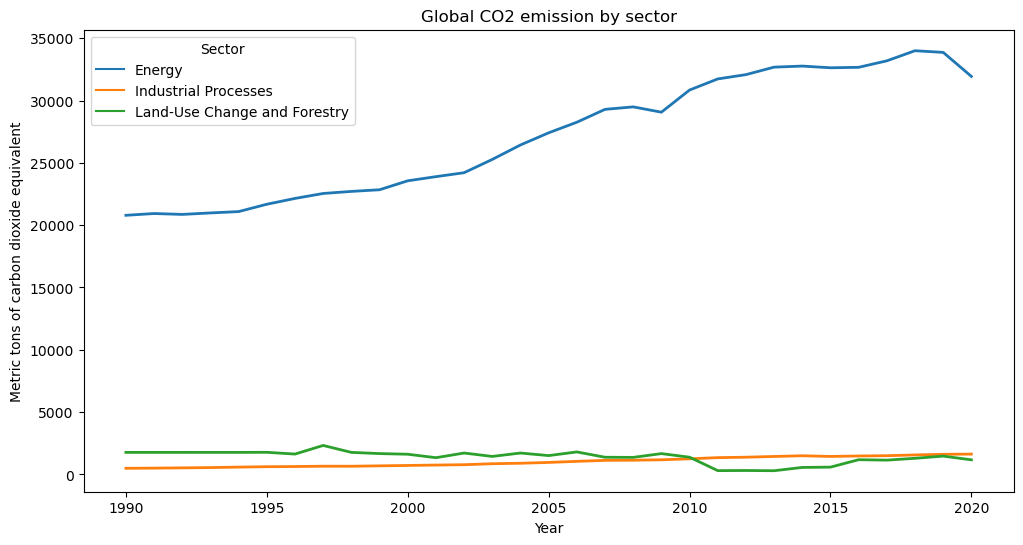

In [17]:
plt.figure(figsize=(12, 6)) 
sns.lineplot(data=co2e_sector, x='year', y='co2_emission', hue='sector', linewidth=2, ci=None)
plt.title('Global CO2 emission by sector')
plt.xlabel('Year')
plt.ylabel('Metric tons of carbon dioxide equivalent')
plt.legend(title='Sector')
plt.show()

Main insights:
- Energy causes by far the most CO2 emissions. We can see that the amount of tCO2 increased over the years but since 2019 the trend is regressive.
- IP and LUCF also account for a small share. 
- Waste and Agriculture do not cause any CO2 emissions at all.

### CO2 emissions (tCO2e per capita) for the energy sector

In [18]:
co2_per_capita = pd.read_csv('./data/co2_emissions_per_capita_energy_sector.csv')
co2_per_capita = co2_per_capita.drop([192, 193, 194]) # drop last three rows 
co2_per_capita = co2_per_capita.drop(columns='unit')
co2_per_capita.columns = [col.lower() for col in co2_per_capita.columns]
co2_per_capita.columns = [col.replace(' ', '_') for col in co2_per_capita.columns]
co2_per_capita = co2_per_capita.rename(columns={'iso': 'country_code', 'country/region': 'country'})
co2_per_capita = co2_per_capita.replace('false', '')
co2_per_capita

,country_code,country,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,CHN,China,1.84,1.91,1.97,2.12,2.18,2.41,2.36,2.38,...,6.37,6.52,6.77,6.74,6.62,6.57,6.68,6.97,7.06,7.15
1,USA,United States,19.27,18.87,18.89,19.08,19.12,19.08,19.44,20.19,...,16.50,15.68,16.00,15.92,15.44,15.03,14.70,15.10,14.55,12.91
2,IND,India,0.62,0.65,0.66,0.67,0.70,0.73,0.75,0.78,...,1.33,1.43,1.46,1.57,1.56,1.56,1.63,1.71,1.67,1.51
3,RUS,Russia,14.62,14.40,13.49,12.52,11.24,10.91,10.72,9.99,...,11.71,11.52,11.19,11.02,10.89,10.75,10.89,11.36,11.66,11.09
4,JPN,Japan,8.52,8.58,8.63,8.54,8.93,9.00,9.08,8.99,...,9.30,9.63,9.73,9.36,9.06,8.96,8.86,8.56,8.28,7.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,FSM,Micronesia,,,1.38,1.44,1.50,1.72,1.76,1.85,...,1.15,1.27,1.31,1.31,1.33,1.33,1.32,1.31,1.30,0.93
188,COK,Cook Islands,,,,,,,,,...,,,,,,,,,,
189,KIR,Kiribati,0.33,0.34,0.34,0.38,0.36,0.39,0.44,0.41,...,0.52,0.54,0.59,0.55,0.55,0.50,0.64,0.63,0.63,0.46
190,NRU,Nauru,13.30,12.95,12.02,11.13,10.61,10.20,9.56,9.62,...,3.99,4.14,4.62,4.91,5.25,5.04,5.29,5.08,4.98,3.56


In [19]:
co2_per_capita = pd.melt(co2_per_capita, id_vars=['country_code', 'country'], var_name='year', value_name='co2_per_capita')
co2_per_capita['year'] = pd.to_numeric(co2_per_capita['year'])
co2_per_capita['co2_per_capita'] = pd.to_numeric(co2_per_capita['co2_per_capita'])
co2_per_capita

,country_code,country,year,co2_per_capita
0,CHN,China,1990,1.84
1,USA,United States,1990,19.27
2,IND,India,1990,0.62
3,RUS,Russia,1990,14.62
4,JPN,Japan,1990,8.52
...,...,...,...,...
5947,FSM,Micronesia,2020,0.93
5948,COK,Cook Islands,2020,NaN
5949,KIR,Kiribati,2020,0.46
5950,NRU,Nauru,2020,3.56


In [20]:
co2_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_code    5952 non-null   object 
 1   country         5952 non-null   object 
 2   year            5952 non-null   int64  
 3   co2_per_capita  5888 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.1+ KB


/var/folders/8y/rwvh8l2506v7ctg86sx8xq2r0000gn/T/ipykernel_58008/2884000555.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=co2_per_capita_top, x='year', y='co2_per_capita', hue='country', linewidth=2, ci=None)


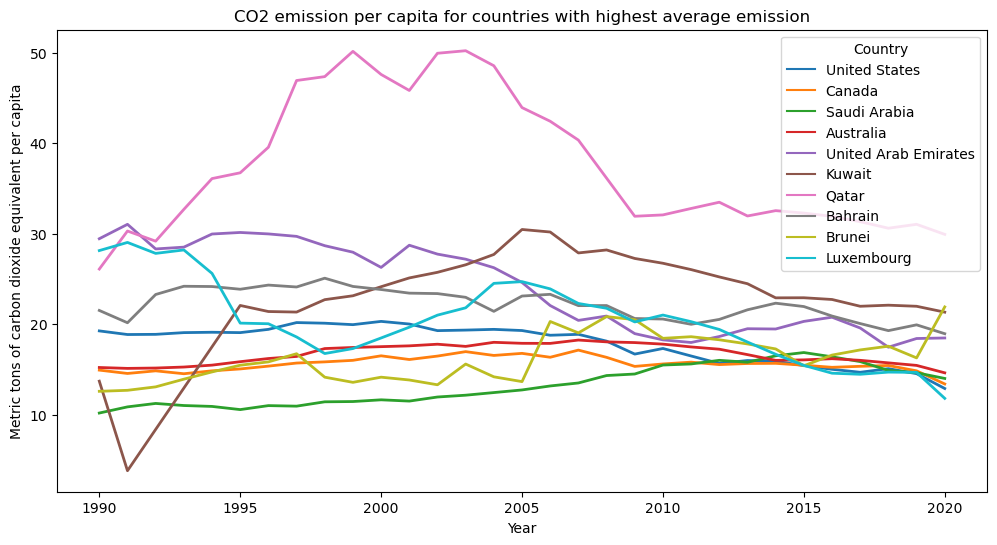

In [21]:
# Calculate average emissions per country
avg_emissions = co2_per_capita.groupby('country')['co2_per_capita'].mean()

# Select top 10 countries with highest average emissions
top_countries = avg_emissions.nlargest(10).index

# Filter the DataFrame to include only data for the top 10 countries
co2_per_capita_top = co2_per_capita[co2_per_capita['country'].isin(top_countries)]

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=co2_per_capita_top, x='year', y='co2_per_capita', hue='country', linewidth=2, ci=None)
plt.title('CO2 emission per capita for countries with highest average emission')
plt.xlabel('Year')
plt.ylabel('Metric tons of carbon dioxide equivalent per capita')
plt.legend(title='Country')
plt.show()

Main insights:
- Qatar is the country with the highest tCO2e emission per capita. 
- In general, the 10 countries with the highest CO2 emission are all developed and a lot of them have high fossil fuel reserves. 
- Luxembourg also appears in the list although it does not produce any oil. This could be explained by fuel tourism and commuters from neighboring countries that are artificially increasing the tCO2e per capita in the country. 


### Create a function to clean emission data 

In [22]:
def emission(file_name, value_name):
    generation_intensity = pd.read_csv(f'./data/{file_name}.csv')
    generation_intensity = gen_intensity.drop([192, 193, 194]) # drop last three rows 
    gen_intensity= df.drop(columns='unit')
    df.columns = [col.lower() for col in df.columns]
    df.columns = [col.replace(' ', '_') for col in df.columns]
    gen_intensity= df.rename(columns={'iso': 'country_code', 'country/region': 'country'})
    gen_intensity= df.replace('false', '')
    gen_intensity= pd.melt(df, id_vars=['country_code', 'country'], var_name='year', value_name=value_name)
    df['year'] = pd.to_numeric(df['year'])
    df[value_name] = pd.to_numeric(df[value_name])
    return df

In [23]:
def emissions_plot(df, column, label_suffix):
    avg_emissions = df.groupby('country')[column].mean()
    # Select top 10 countries with highest average emissions
    top_countries = avg_emissions.nlargest(10).index 
    
    # Filter the DataFrame to include only data for the top 10 countries
    df_top = df[df['country'].isin(top_countries)]

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_top, x='year', y=column, hue='country', linewidth=2, ci=None)
    plt.title(f'CO2 emission {label_suffix} for countries with highest average emission')
    plt.xlabel('Year')
    plt.ylabel(f'Metric tons of carbon dioxide equivalent {label_suffix}')
    plt.legend(title='Country')
    return plt.show()

### CO2 emissions (tCO2e/ million $ GDP) for the energy sector

In [24]:
co2_gdp = cf.emission('co2_emissions_per_gdp_energy_sector', 'co2_emission_per_mio_usd')
co2_gdp

,country_code,country,year,co2_emission_per_mio_usd
0,CHN,China,1990,5788.58
1,USA,United States,1990,806.80
2,IND,India,1990,1686.17
3,RUS,Russia,1990,4186.29
4,JPN,Japan,1990,335.74
...,...,...,...,...
5947,FSM,Micronesia,2020,262.08
5948,COK,Cook Islands,2020,NaN
5949,KIR,Kiribati,2020,305.12
5950,NRU,Nauru,2020,336.75


/Users/trinakohestani/neuefische/capstone-project/config.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_top, x='year', y=column, hue='country', linewidth=2, ci=None)


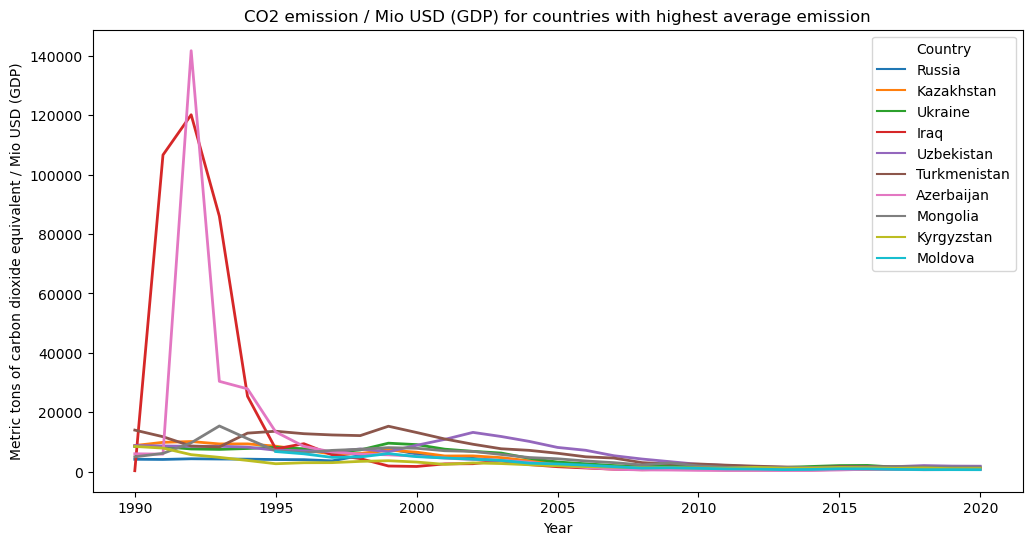

In [25]:
cf.emissions_plot(co2_gdp, 'co2_emission_per_mio_usd', '/ Mio USD (GDP)')

Main insights:
- Azerbaijan and Iraq accounted for a enormous amount of CO2 emission between 1990 and 1995. 
- For Azerbaijan this can be explained by expansion of its oil and gas industry, outdated technology and inefficient processes inherited from the Soviet era, economic transition challenges, and extensive gas flaring.
- Iraqs emissions were driven by the Gulf War's destruction, subsequent reconstruction efforts, reliance on inefficient oil production, economic sanctions, and weak environmental regulations.
- We can also see that the trend is going downwards for all countries in the past 20 years. 

/Users/trinakohestani/neuefische/capstone-project/config.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_top, x='year', y=column, hue='country', linewidth=2, ci=None)


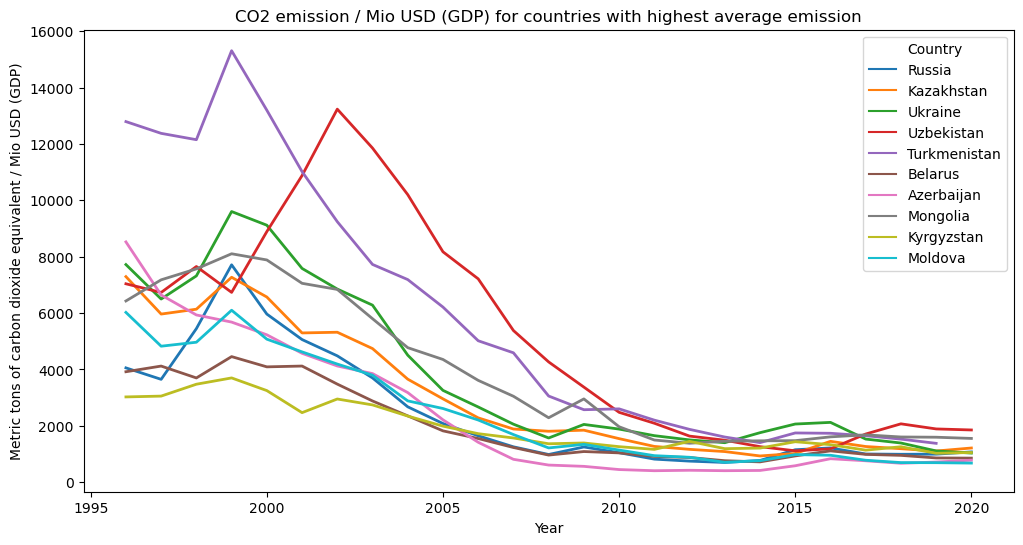

In [26]:
co2_gdp_1995 = co2_gdp[co2_gdp['year'] > 1995]
cf.emissions_plot(co2_gdp_1995, 'co2_emission_per_mio_usd', '/ Mio USD (GDP)')

Main insights:
- A lot of these countries belonged to the Soviet Union and gained independence following the dissolution of the Soviet Union in 1991.
- The high CO2 emissions were due to economic transition, increased industrial and energy activities, inefficient infrastructure, and weak environmental regulations.

### GHG emissions (MtCO2e) by sector 

In [27]:
ghge_sector = pd.read_csv('./data/ghg_emissions_by_sector.csv')
ghge_sector = ghge_sector.drop([5,6]) # drop these rows as they are null 
ghge_sector = ghge_sector.drop(columns='unit')
ghge_sector.columns = [col.lower() for col in ghge_sector.columns]
ghge_sector.columns = [col.replace(' ', '_') for col in ghge_sector.columns]
ghge_sector

,sector,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Energy,23283.88,23432.48,23315.17,23450.49,23551.65,24210.55,24730.57,25150.27,25315.23,...,35241.09,35641.95,36273.52,36383.40,36236.70,36239.01,36804.52,37707.06,37612.13,35475.65
1,Industrial Processes,1002.76,1007.48,1022.92,1039.53,1147.93,1220.88,1272.44,1321.72,1325.97,...,2380.64,2463.49,2576.95,2699.79,2692.99,2789.84,2858.25,2967.21,3064.20,3126.93
2,Agriculture,4978.93,4968.92,4948.40,4917.90,4960.66,5015.77,5042.65,4972.12,5027.44,...,5625.86,5648.32,5587.69,5638.52,5662.32,5698.38,5788.58,5788.68,5783.42,5865.47
3,Waste,1364.40,1395.18,1418.28,1444.39,1470.96,1476.51,1478.31,1474.36,1466.28,...,1467.31,1476.63,1484.04,1514.26,1543.59,1560.85,1583.86,1606.86,1629.87,1652.87
4,Land-Use Change and Forestry,2031.44,2031.44,2031.44,2031.88,2031.55,2037.15,1827.03,2796.53,2126.31,...,541.57,569.77,521.40,870.51,924.17,1403.75,1355.71,1516.09,1790.99,1392.23


In [28]:
ghge_sector = pd.melt(ghge_sector, id_vars='sector', var_name='year', value_name='ghg_emission')
ghge_sector['year'] = pd.to_numeric(ghge_sector['year'])
ghge_sector['ghg_emission'] = pd.to_numeric(ghge_sector['ghg_emission'])
ghge_sector

,sector,year,ghg_emission
0,Energy,1990,23283.88
1,Industrial Processes,1990,1002.76
2,Agriculture,1990,4978.93
3,Waste,1990,1364.40
4,Land-Use Change and Forestry,1990,2031.44
...,...,...,...
150,Energy,2020,35475.65
151,Industrial Processes,2020,3126.93
152,Agriculture,2020,5865.47
153,Waste,2020,1652.87


/var/folders/8y/rwvh8l2506v7ctg86sx8xq2r0000gn/T/ipykernel_58008/952481192.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=ghge_sector, x='year', y='ghg_emission', hue='sector', linewidth=2, ci=None)


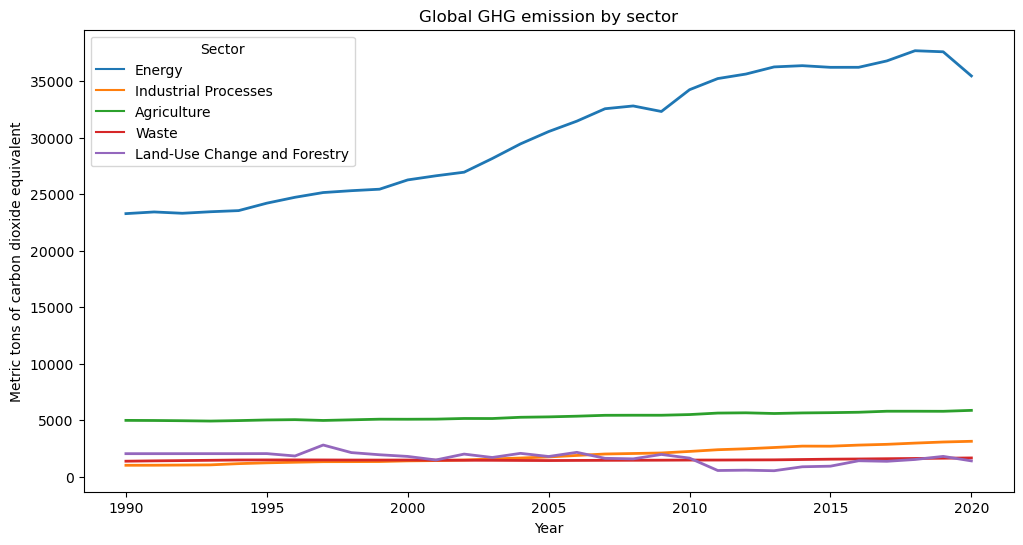

In [29]:
plt.figure(figsize=(12, 6)) 
sns.lineplot(data=ghge_sector, x='year', y='ghg_emission', hue='sector', linewidth=2, ci=None)
plt.title('Global GHG emission by sector')
plt.xlabel('Year')
plt.ylabel('Metric tons of carbon dioxide equivalent')
plt.legend(title='Sector')
plt.show()

Main insights:
- Energy also accounts by far for the highest amount of GHG emissions. 
- The trend was upwards since 1990s but also regressed in the past few years (maybe due to the use of renewable energies?).

### GHG emissions (tCO2e per capita) for the energy sector

In [30]:
ghg_per_capita = cf.emission('ghg_emissions_per_capita_energy_sector', 'ghg_emission_per_capita')
ghg_per_capita

,country_code,country,year,ghg_emission_per_capita
0,CHN,China,1990,2.08
1,USA,United States,1990,20.57
2,IND,India,1990,0.71
3,RUS,Russia,1990,17.51
4,JPN,Japan,1990,8.62
...,...,...,...,...
5947,FSM,Micronesia,2020,0.93
5948,COK,Cook Islands,2020,NaN
5949,KIR,Kiribati,2020,0.48
5950,NRU,Nauru,2020,3.82


/Users/trinakohestani/neuefische/capstone-project/config.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_top, x='year', y=column, hue='country', linewidth=2, ci=None)


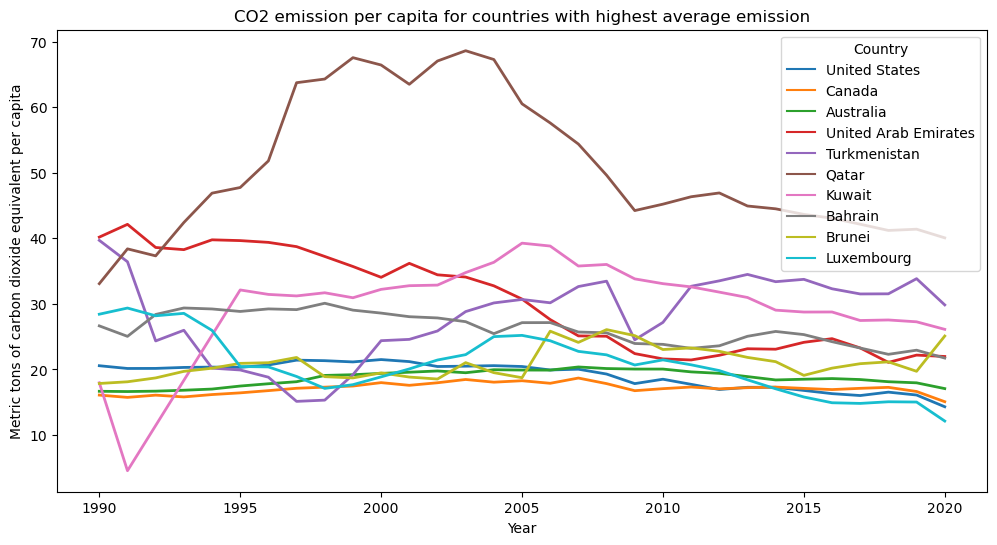

In [31]:
cf.emissions_plot(ghg_per_capita, 'ghg_emission_per_capita', 'per capita')

Main insights:
- Qatar is the country with the highest GHG emission per capita. 
- In general, the 10 countries with the highest CO2 emission are all developed and a lot of them have high oil reserves. 
- Luxembourg also appears in the list although it does not produce any oil. This could be explained by fuel tourism and commuters from neighboring countries that are artificially increasing the tCO2e per capita in the country. 

### GHG emissions (tCO2e/ million $ GDP) for the energy sector

In [32]:
ghg_gdp = cf.emission('ghg_emissions_per_gdp_energy_sector', 'ghg_emission_per_mio_usd')
ghg_gdp

,country_code,country,year,ghg_emission_per_mio_usd
0,CHN,China,1990,6537.34
1,USA,United States,1990,861.15
2,IND,India,1990,1934.58
3,RUS,Russia,1990,5013.07
4,JPN,Japan,1990,339.82
...,...,...,...,...
5947,FSM,Micronesia,2020,263.79
5948,COK,Cook Islands,2020,NaN
5949,KIR,Kiribati,2020,314.52
5950,NRU,Nauru,2020,361.17


/var/folders/8y/rwvh8l2506v7ctg86sx8xq2r0000gn/T/ipykernel_58008/2695547059.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_top, x='year', y=column, hue='country', linewidth=2, ci=None)


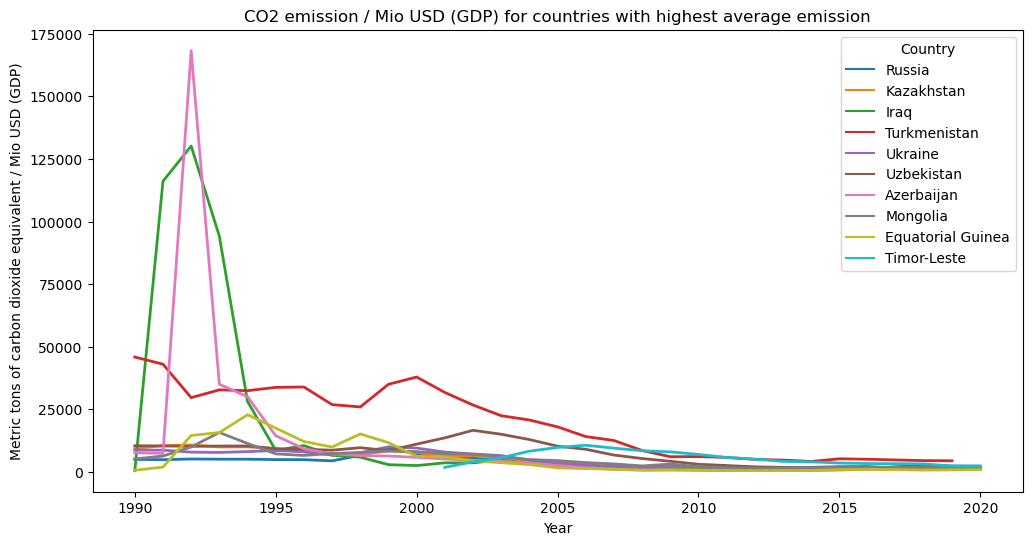

In [33]:
emissions_plot(ghg_gdp, 'ghg_emission_per_mio_usd', '/ Mio USD (GDP)')

Main insights:
- Azerbaijan and Iraq accounted for a enormous amount of GHG emission between 1990 and 1995 related to its CO2 emissions.
- Turkmenistan's high GHG emissions are largely driven by methane from natural gas production and agricultural activities, whereas its CO2 emissions are comparatively lower due to less reliance on coal and oil for energy and industrial production.

/var/folders/8y/rwvh8l2506v7ctg86sx8xq2r0000gn/T/ipykernel_58008/2695547059.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_top, x='year', y=column, hue='country', linewidth=2, ci=None)


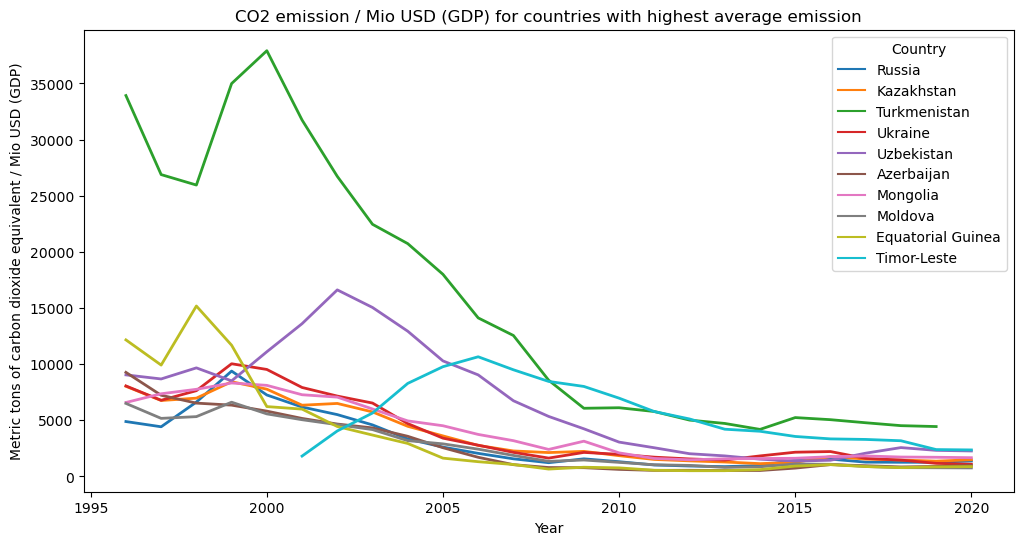

In [34]:
ghg_gdp_1995 = ghg_gdp[ghg_gdp['year'] > 1995]
emissions_plot(ghg_gdp_1995, 'ghg_emission_per_mio_usd', '/ Mio USD (GDP)')

Main insights:
- Timor-Leste's high GHG emissions are mainly due to deforestation, traditional agricultural practices, reliance on fossil fuels, and the ongoing process of economic development with limited access to energy-efficient technologies.
- Equatorial Guinea's high GHG emissions are primarily driven by its oil and gas industry, industrial activities, deforestation, limited renewable energy development, rapid economic growth, and population dynamics.

## Merge dataframes

### CO2 and GHG emission by sector

In [35]:
ghge_sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sector        155 non-null    object 
 1   year          155 non-null    int64  
 2   ghg_emission  155 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.8+ KB


In [36]:
co2e_sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sector        93 non-null     object 
 1   year          93 non-null     int64  
 2   co2_emission  93 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ KB


In [37]:
co2_ghg_sector = ghge_sector.merge(co2e_sector, how='outer', on=['sector', 'year'])
co2_ghg_sector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sector        155 non-null    object 
 1   year          155 non-null    int64  
 2   ghg_emission  155 non-null    float64
 3   co2_emission  93 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 6.1+ KB


### GHG and CO2 emission per capita 

In [38]:
co2_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country_code              5952 non-null   object 
 1   country                   5952 non-null   object 
 2   year                      5952 non-null   int64  
 3   co2_emission_per_mio_usd  5683 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.1+ KB


In [39]:
co2_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_code    5952 non-null   object 
 1   country         5952 non-null   object 
 2   year            5952 non-null   int64  
 3   co2_per_capita  5888 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.1+ KB


In [40]:
ghg_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country_code              5952 non-null   object 
 1   country                   5952 non-null   object 
 2   year                      5952 non-null   int64  
 3   ghg_emission_per_mio_usd  5684 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.1+ KB


In [41]:
ghg_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country_code             5952 non-null   object 
 1   country                  5952 non-null   object 
 2   year                     5952 non-null   int64  
 3   ghg_emission_per_capita  5891 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.1+ KB


In [42]:
ghg_co2_country = co2_gdp.merge(co2_per_capita, how='outer', on=['country', 'country_code', 'year'])
ghg_co2_country = ghg_co2_country.merge(ghg_gdp, how='outer', on=['country', 'country_code', 'year'])
ghg_co2_country = ghg_co2_country.merge(ghg_per_capita, how='outer', on=['country', 'country_code', 'year'])
ghg_co2_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country_code              5952 non-null   object 
 1   country                   5952 non-null   object 
 2   year                      5952 non-null   int64  
 3   co2_emission_per_mio_usd  5683 non-null   float64
 4   co2_per_capita            5888 non-null   float64
 5   ghg_emission_per_mio_usd  5684 non-null   float64
 6   ghg_emission_per_capita   5891 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 372.0+ KB


In [43]:
ghg_co2_country.head()

,country_code,country,year,co2_emission_per_mio_usd,co2_per_capita,ghg_emission_per_mio_usd,ghg_emission_per_capita
0,CHN,China,1990,5788.58,1.84,6537.34,2.08
1,USA,United States,1990,806.80,19.27,861.15,20.57
2,IND,India,1990,1686.17,0.62,1934.58,0.71
3,RUS,Russia,1990,4186.29,14.62,5013.07,17.51
4,JPN,Japan,1990,335.74,8.52,339.82,8.62


## Carbon intensity (gco2 per kwh)

In [44]:
import requests

query_url = ('https://api.ember-climate.org/v1/carbon-intensity/yearly?start_date=2000&end_date=2022&include_all_dates_value_range=false&api_key=26edeb40-5647-4b63-9a69-462ac85de331')

response = requests.get(query_url)

if response.status_code == 200:
    data = response.json()

In [45]:
carbon_intensity = pd.json_normalize(data["data"], sep="_")
carbon_intensity = carbon_intensity.rename(columns={'entity_code': 'country_code', 'entity': 'country', 'date':'year', 'emissions_intensity_gco2_per_kwh':'carbon_intensity'})
carbon_intensity['year'] = pd.to_numeric(carbon_intensity['year'])
carbon_intensity = carbon_intensity.drop(columns='is_aggregate_entity')
carbon_intensity

,country,country_code,year,carbon_intensity
0,Afghanistan,AFG,2000,250.00
1,Afghanistan,AFG,2001,217.39
2,Afghanistan,AFG,2002,169.01
3,Afghanistan,AFG,2003,241.76
4,Afghanistan,AFG,2004,227.85
...,...,...,...,...
5207,Zimbabwe,ZWE,2018,395.13
5208,Zimbabwe,ZWE,2019,428.74
5209,Zimbabwe,ZWE,2020,371.09
5210,Zimbabwe,ZWE,2021,270.69


In [46]:
carbon_intensity.to_csv('./data/carbon_intensity')

/var/folders/8y/rwvh8l2506v7ctg86sx8xq2r0000gn/T/ipykernel_58008/1335470738.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=carbon_intensity_top, x='year', y='carbon_intensity', hue='country', linewidth=2, ci=None)


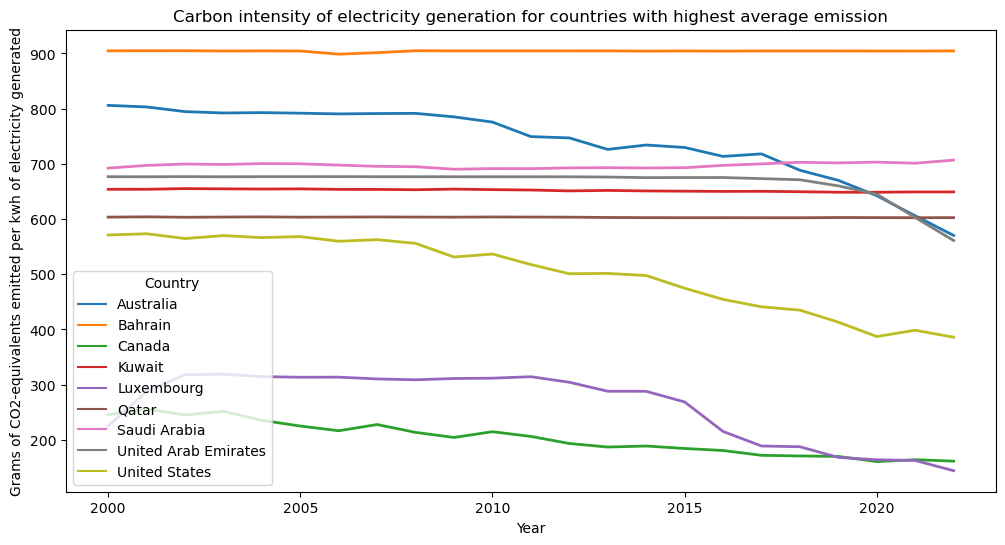

In [47]:
# Calculate average emissions per country
avg_cintensity = carbon_intensity.groupby('country')['carbon_intensity'].mean()

# Select top 10 countries with highest average emissions
top_countries = avg_emissions.nlargest(10).index

# Filter the DataFrame to include only data for the top 10 countries
carbon_intensity_top = carbon_intensity[carbon_intensity['country'].isin(top_countries)]

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=carbon_intensity_top, x='year', y='carbon_intensity', hue='country', linewidth=2, ci=None)
plt.title('Carbon intensity of electricity generation for countries with highest average emission')
plt.xlabel('Year')
plt.ylabel('Grams of CO2-equivalents emitted per kwh of electricity generated')
plt.legend(title='Country')
plt.show()

Main insights:
- Bahrain has the highest average carbon intensity of electricity generation with around 900 gCO2e/kwh. 
- For Bahrain, Kuwait, Qatar and Saudi Arabia the value is constant in for the entire period under consideration. 
- For UAE, it was constant from 2000 to 2018 but also starts to decrease in the past years. This suggests that the UAE has implemented measures to reduce the carbon footprint of its electricity generation, such as increasing the share of renewable energy sources, improving energy efficiency, or adopting cleaner technologies.

### Merging carbon_intensity to ghg_co2_country

In [48]:
emissions = ghg_co2_country.merge(carbon_intensity, how='outer', on=['country_code', 'year'])
emissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 0 to 7272
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country_code              6974 non-null   object 
 1   country_x                 5952 non-null   object 
 2   year                      7273 non-null   int64  
 3   co2_emission_per_mio_usd  5683 non-null   float64
 4   co2_per_capita            5888 non-null   float64
 5   ghg_emission_per_mio_usd  5684 non-null   float64
 6   ghg_emission_per_capita   5891 non-null   float64
 7   country_y                 5212 non-null   object 
 8   carbon_intensity          5184 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 568.2+ KB


In [49]:
emissions.drop(columns='country_y', inplace=True)
emissions = emissions.rename(columns={'country_x': 'country'})
emissions

,country_code,country,year,co2_emission_per_mio_usd,co2_per_capita,ghg_emission_per_mio_usd,ghg_emission_per_capita,carbon_intensity
0,CHN,China,1990,5788.58,1.84,6537.34,2.08,NaN
1,USA,United States,1990,806.80,19.27,861.15,20.57,NaN
2,IND,India,1990,1686.17,0.62,1934.58,0.71,NaN
3,RUS,Russia,1990,4186.29,14.62,5013.07,17.51,NaN
4,JPN,Japan,1990,335.74,8.52,339.82,8.62,NaN
...,...,...,...,...,...,...,...,...
7268,YEM,NaN,2022,NaN,NaN,NaN,NaN,566.10
7269,ZMB,NaN,2021,NaN,NaN,NaN,NaN,86.91
7270,ZMB,NaN,2022,NaN,NaN,NaN,NaN,111.97
7271,ZWE,NaN,2021,NaN,NaN,NaN,NaN,270.69


## Generation Intensity
This metric represents the amount of electricity generated per unit of installed capacity.

**Formula:**

$$
\text{Generation Intensity} = \frac{\text{Electricity Generation (GWh)}}{\text{Electricity Installed Capacity (MW)}}
$$

Compute the generation intensity for renewable energy in each country-year observation by dividing the electricity generation (measured in GWh) by the installed capacity (measured in MW). 



In [50]:
gen_intensity = pd.read_csv('./data_clean/re_indicators.csv', delimiter=',', index_col=0)
# Grouping by year and type, and calculating the sum for electricity generation and capacity
gen_intensity = gen_intensity.groupby(['year', 'type']).sum(numeric_only=True).reset_index()
gen_intensity = gen_intensity[gen_intensity['year'] != "2023-01-01"]
gen_intensity['generation_intensity'] = gen_intensity.apply(
    lambda row: row['electricity_generation_gwh'] / row['electricity_capacity_mw'] if row['electricity_capacity_mw'] != 0 else 0,
    axis=1)
gen_intensity

,year,type,electricity_generation_gwh,electricity_capacity_mw,generation_intensity
0,2000-01-01,Biofuels,128118.622,24765.240,5.173324
1,2000-01-01,Geothermal,52571.035,8272.700,6.354761
2,2000-01-01,Hydropower,2614270.604,697169.998,3.749832
3,2000-01-01,Others,18438.738,3803.130,4.848306
4,2000-01-01,Solar,1330.912,1224.691,1.086733
...,...,...,...,...,...
156,2022-01-01,Hydropower,1423853.885,1260882.706,1.129252
157,2022-01-01,Others,53696.999,20916.082,2.567259
158,2022-01-01,Solar,442904.326,1073135.531,0.412720
159,2022-01-01,Total Renewable,2815483.910,3396323.388,0.828980


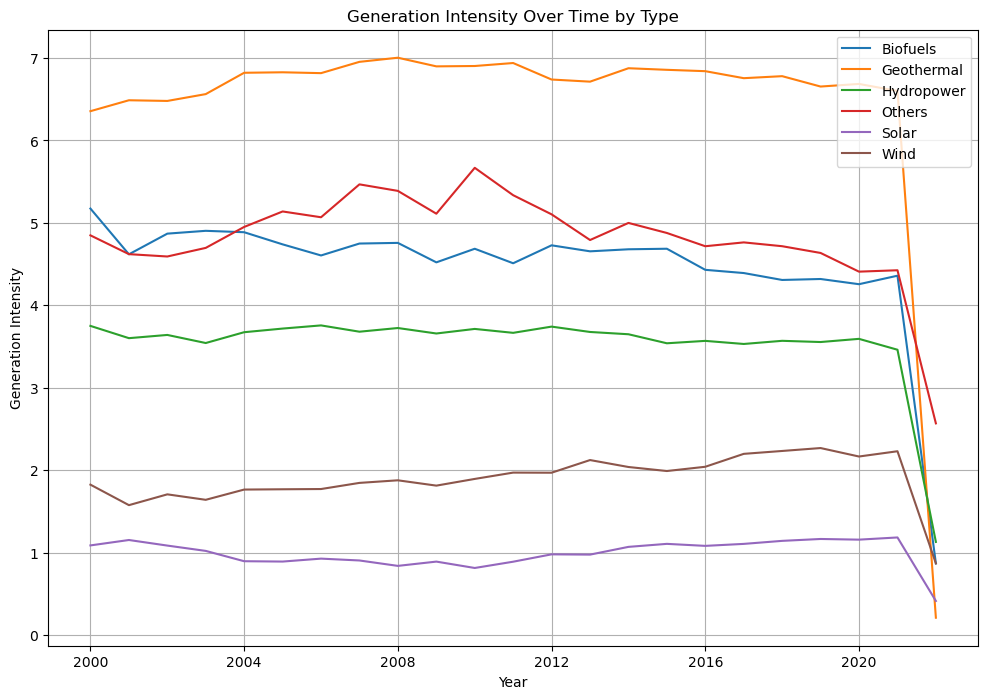

In [51]:
# Converting the 'year' column to datetime format
gen_intensity['year'] = pd.to_datetime(gen_intensity['year'])

# Pivoting the DataFrame for the line plot
pivot_gen_intensity= gen_intensity.pivot(index='year', columns='type', values='generation_intensity')

# Plotting the line chart
plt.figure(figsize=(12, 8))
for column in pivot_gen_intensity.columns:
    if column != "Total Renewable":
        plt.plot(pivot_gen_intensity.index, pivot_gen_intensity[column], label=column)

plt.xlabel('Year')
plt.ylabel('Generation Intensity')
plt.title('Generation Intensity Over Time by Type')
plt.legend()
plt.grid(True)
plt.show()

## Economic Development

### GDP per capita (current USD) 

In [53]:
gdp_per_capita = pd.read_csv('./data/gdp_per_capita.csv')
gdp_per_capita.columns = [col.lower() for col in gdp_per_capita.columns]
gdp_per_capita.columns = [col.replace(' ', '_') for col in gdp_per_capita.columns]
gdp_per_capita.columns = gdp_per_capita.columns.str.replace(r'_\[yr\d{4}\]', '', regex=True)
gdp_per_capita = gdp_per_capita.rename(columns={'country_name': 'country'})
gdp_per_capita = pd.melt(gdp_per_capita, id_vars=['country', 'country_code'], var_name='year', value_name='gdp_per_capita_usd')
gdp_per_capita['year'] = pd.to_numeric(gdp_per_capita['year'])
gdp_per_capita['gdp_per_capita_usd'] = gdp_per_capita['gdp_per_capita_usd'].replace('..', np.nan) # Replace empty strings with NaN
gdp_per_capita['gdp_per_capita_usd'] = gdp_per_capita['gdp_per_capita_usd'].astype(float) # Convert the column to float

In [54]:
gdp_per_capita

,country,country_code,year,gdp_per_capita_usd
0,Afghanistan,AFG,2000,NaN
1,Albania,ALB,2000,1126.683340
2,Algeria,DZA,2000,1780.376063
3,American Samoa,ASM,2000,NaN
4,Andorra,AND,2000,21620.465100
...,...,...,...,...
6379,Sub-Saharan Africa,SSF,2023,NaN
6380,Sub-Saharan Africa (excluding high income),SSA,2023,NaN
6381,Sub-Saharan Africa (IDA & IBRD countries),TSS,2023,NaN
6382,Upper middle income,UMC,2023,NaN


In [55]:
gdp_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             6384 non-null   object 
 1   country_code        6384 non-null   object 
 2   year                6384 non-null   int64  
 3   gdp_per_capita_usd  5876 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 199.6+ KB


### Total GDP (current USD)

In [56]:
total_gdp = pd.read_excel('./data/total_gdp.xlsx')
total_gdp = total_gdp.drop([266]) # drop last row
total_gdp = total_gdp.drop(columns='Unnamed: 4')
total_gdp.columns = [col.lower() for col in total_gdp.columns]
total_gdp.columns = [col.replace(' ', '_') for col in total_gdp.columns]
total_gdp = total_gdp.rename(columns={total_gdp.columns[0]: 'country'})
total_gdp = pd.melt(total_gdp, id_vars=['country'], var_name='year', value_name='total_gdp_usd')
total_gdp['year'] = pd.to_numeric(total_gdp['year'])
total_gdp['total_gdp_usd'] = total_gdp['total_gdp_usd'].replace('..', np.nan) # Replace empty strings with NaN
total_gdp['total_gdp_usd'] = total_gdp['total_gdp_usd'].str.replace(',', '')
total_gdp['total_gdp_usd'] = total_gdp['total_gdp_usd'].astype(float) # Convert the column to float

In [57]:
total_gdp

,country,year,total_gdp_usd
0,Afghanistan,2000,NaN
1,Albania,2000,3.480355e+09
2,Algeria,2000,5.479040e+10
3,American Samoa,2000,NaN
4,Andorra,2000,1.429048e+09
...,...,...,...
6379,Sub-Saharan Africa,2023,NaN
6380,Sub-Saharan Africa (excluding high income),2023,NaN
6381,Sub-Saharan Africa (IDA & IBRD countries),2023,NaN
6382,Upper middle income,2023,NaN


In [58]:
total_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        6384 non-null   object 
 1   year           6384 non-null   int64  
 2   total_gdp_usd  5872 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 149.8+ KB


### Industry (including construction), value-added (% of GDP)

In [59]:
industry = pd.read_csv('./data/industry_%.csv')
industry.columns = [col.lower() for col in industry.columns]
industry.columns = [col.replace(' ', '_') for col in industry.columns]
industry.columns = industry.columns.str.replace(r'_\[yr\d{4}\]', '', regex=True)
industry = industry.rename(columns={'country_name': 'country'})
industry = pd.melt(industry, id_vars=['country', 'country_code'], var_name='year', value_name='industry_%')
industry['year'] = pd.to_numeric(industry['year'])
industry['industry_%'] = industry['industry_%'].replace('..', np.nan) # Replace empty strings with NaN
industry['industry_%'] = industry['industry_%'].astype(float) # Convert the column to float

In [60]:
industry

,country,country_code,year,industry_%
0,Afghanistan,AFG,2000,NaN
1,Albania,ALB,2000,19.395689
2,Algeria,DZA,2000,53.330970
3,American Samoa,ASM,2000,NaN
4,Andorra,AND,2000,14.843755
...,...,...,...,...
6379,Sub-Saharan Africa,SSF,2023,NaN
6380,Sub-Saharan Africa (excluding high income),SSA,2023,NaN
6381,Sub-Saharan Africa (IDA & IBRD countries),TSS,2023,NaN
6382,Upper middle income,UMC,2023,NaN


### Total population

In [61]:
total_population = pd.read_csv('./data/total_population.csv')
total_population.columns = [col.lower() for col in total_population.columns]
total_population.columns = [col.replace(' ', '_') for col in total_population.columns]
total_population.columns = total_population.columns.str.replace(r'_\[yr\d{4}\]', '', regex=True)
total_population = total_population.rename(columns={'country_name': 'country'})
total_population = pd.melt(total_population, id_vars=['country', 'country_code'], var_name='year', value_name='total_population_usd')
total_population['year'] = pd.to_numeric(total_population['year'])
total_population['total_population_usd'] = total_population['total_population_usd'].replace('..', np.nan) # Replace empty strings with NaN
total_population['total_population_usd'] = total_population['total_population_usd'].astype(float) # Convert the column to float

In [62]:
total_population

,country,country_code,year,total_population_usd
0,Afghanistan,AFG,2000,19542982.0
1,Albania,ALB,2000,3089027.0
2,Algeria,DZA,2000,30774621.0
3,American Samoa,ASM,2000,58230.0
4,Andorra,AND,2000,66097.0
...,...,...,...,...
6379,Sub-Saharan Africa,SSF,2023,NaN
6380,Sub-Saharan Africa (excluding high income),SSA,2023,NaN
6381,Sub-Saharan Africa (IDA & IBRD countries),TSS,2023,NaN
6382,Upper middle income,UMC,2023,NaN


In [63]:
gdp_population = gdp_per_capita.merge(total_gdp, how='inner', on=['country', 'year'])
gdp_population = gdp_population.merge(total_population, how='inner', on=['country', 'country_code', 'year'])
gdp_population = gdp_population.merge(industry, how='inner', on=['country', 'country_code', 'year'])
gdp_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6384 entries, 0 to 6383
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               6384 non-null   object 
 1   country_code          6384 non-null   object 
 2   year                  6384 non-null   int64  
 3   gdp_per_capita_usd    5876 non-null   float64
 4   total_gdp_usd         5872 non-null   float64
 5   total_population_usd  6095 non-null   float64
 6   industry_%            5524 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 399.0+ KB


## Changing the country names in renewable_energy and re_share

In [65]:
# Rename countries in renewable_energy that do not contain the name in emissions
renewable_energy = renewable_energy.replace("Democratic People's Republic of Korea (the)", "North Korea")
renewable_energy = renewable_energy.replace("Republic of Korea (the)", "South Korea")
renewable_energy = renewable_energy.replace("Lao People's Democratic Republic (the)", "Laos")
renewable_energy = renewable_energy.replace("Viet Nam", "Vietnam")
renewable_energy = renewable_energy.replace("Czechia", "Czech Republic")
renewable_energy = renewable_energy.replace("Congo (the)", "Republic of Congo")

# Rename Dom.Rep. of Congo to country 1
renewable_energy = renewable_energy.replace("Democratic Republic of the Congo (the)", "Country 1")
ghg_co2_country = ghg_co2_country.replace("Democratic Republic of the Congo", "Country 1")

# Rename Dominican Republic to country 2
renewable_energy = renewable_energy.replace("Dominican Republic (the)", "Country 2")
ghg_co2_country = ghg_co2_country.replace("Dominican Republic", "Country 2")

# Write a loop for all the other countries that do not match
for country in ghg_co2_country["country"].unique(): 
    renewable_energy.loc[renewable_energy['country'].str.contains(country, case=False), 'country'] = country

# Rename Dom.Rep. of Congo to country 1
renewable_energy = renewable_energy.replace("Country 1", "Democratic Republic of the Congo")
ghg_co2_country = ghg_co2_country.replace("Country 1", "Democratic Republic of the Congo")

# Rename Dominican Republic back
renewable_energy = renewable_energy.replace("Country 2", "Dominican Republic")
ghg_co2_country = ghg_co2_country.replace("Country 2", "Dominican Republic")

renewable_energy = renewable_energy.groupby(['country', 'year', 'type']).agg({
        'electricity_generation_gwh': 'sum',
        'electricity_capacity_mw': 'sum'
    }).reset_index()

In [66]:
renewable_energy[renewable_energy['country']=="Côte d'Ivoire"]

,country,year,type,electricity_generation_gwh,electricity_capacity_mw
8568,Côte d'Ivoire,2000,Biofuels,0.0,0.000
8569,Côte d'Ivoire,2000,Geothermal,0.0,0.000
8570,Côte d'Ivoire,2000,Hydropower,1764.0,604.000
8571,Côte d'Ivoire,2000,Others,0.0,0.000
8572,Côte d'Ivoire,2000,Solar,0.0,0.000
...,...,...,...,...,...
8731,Côte d'Ivoire,2023,Hydropower,0.0,879.000
8732,Côte d'Ivoire,2023,Others,0.0,0.000
8733,Côte d'Ivoire,2023,Solar,0.0,46.499
8734,Côte d'Ivoire,2023,Total Renewable,0.0,925.499


In [67]:
# Rename countries in re_share that do not contain the name in emissions
re_share = re_share.replace("Democratic People's Republic of Korea (the)", "North Korea")
re_share = re_share.replace("Republic of Korea (the)", "South Korea")
re_share = re_share.replace("Lao People's Democratic Republic (the)", "Laos")
re_share = re_share.replace("Viet Nam", "Vietnam")
re_share = re_share.replace("United States Virgin Islands", "Virgin Islands")
re_share = re_share.replace("Czechia", "Czech Republic")
re_share = re_share.replace("Congo", "Republic of Congo")

# Rename Dom.Rep. of Congo to country 1
re_share = re_share.replace("Democratic Republic of the Congo", "Country 1")
ghg_co2_country = ghg_co2_country.replace("Democratic Republic of the Congo", "Country 1")

# Rename Dominican Republic to country 2
re_share = re_share.replace("Dominican Republic", "Country 2")
ghg_co2_country = ghg_co2_country.replace("Dominican Republic", "Country 2")

# Write a loop for all the other countries that do not match
for country in ghg_co2_country['country'].unique(): 
    re_share.loc[re_share['country'].str.contains(country, case=False), 'country'] = country

# Rename Dom.Rep. of Congo to country 1
re_share = re_share.replace("Country 1", "Democratic Republic of the Congo")
ghg_co2_country = ghg_co2_country.replace("Country 1", "Democratic Republic of the Congo")

# Rename Dominican Republic back
re_share = re_share.replace("Country 2", "Dominican Republic")
ghg_co2_country = ghg_co2_country.replace("Country 2", "Dominican Republic")

In [68]:
# Merge the datasets based on 'country_code' and 'year'
merged_df = pd.merge(ghg_co2_country[['country_code', 'country', 'year']], re_share_con, on=['country_code', 'year'], how='inner')
merged_df = merged_df.drop(columns='country_y')
merged_df = merged_df.rename(columns={'country_x': 'country'})

# Sort the dataframe by country, country_code, and year in ascending order and reset the index
merged_df_sorted = merged_df.sort_values(by=['country_code','country', 'year'], ascending=True).reset_index(drop=True)

# Display the first few rows of the sorted dataframe
merged_df

,country_code,country,year,share_con_%
0,CHN,China,2000,29.63
1,USA,United States,2000,5.43
2,IND,India,2000,46.88
3,RUS,Russia,2000,3.50
4,JPN,Japan,2000,3.70
...,...,...,...,...
4006,MHL,Marshall Islands,2020,11.97
4007,FSM,Micronesia,2020,2.03
4008,KIR,Kiribati,2020,42.75
4009,NRU,Nauru,2020,1.40


In [69]:
merged_df[merged_df['country']=='Republic of Congo'].head()

,country_code,country,year,share_con_%
113,COG,Republic of Congo,2000,64.86
304,COG,Republic of Congo,2001,61.18
495,COG,Republic of Congo,2002,68.53
686,COG,Republic of Congo,2003,61.99
877,COG,Republic of Congo,2004,63.03


In [70]:
re_share = re_share.merge(merged_df, how='outer', on=['country', 'year'])
# Reorder the columns
ordered_columns = ['country', 'country_code', 'year', 'share_cap_%', 'share_gen_%', 'share_con_%']
re_share = re_share[ordered_columns]
# Sort the dataframe by 'country', 'country_code', and 'year' in ascending order and reset the index
re_share = re_share.sort_values(by=['country', 'country_code', 'year'], ascending=True).reset_index(drop=True)

In [71]:
re_share[re_share['country']=='Republic of Congo'].head()

,country,country_code,year,share_cap_%,share_gen_%,share_con_%
4172,Republic of Congo,COG,2000,75.48,99.02,64.86
4173,Republic of Congo,COG,2001,75.48,99.96,61.18
4174,Republic of Congo,COG,2002,61.93,99.87,68.53
4175,Republic of Congo,COG,2003,61.93,86.76,61.99
4176,Republic of Congo,COG,2004,61.93,84.17,63.03


Carbon intensity

In [72]:
'''
# Rename countries in carbon_intensity that do not contain the name in emissions
carbon_intensity = carbon_intensity.replace("Democratic People's Republic of Korea (the)", "North Korea")
carbon_intensity = carbon_intensity.replace("Republic of Korea (the)", "South Korea")
carbon_intensity = carbon_intensity.replace("Lao People's Democratic Republic (the)", "Laos")
carbon_intensity = carbon_intensity.replace("Viet Nam", "Vietnam")
carbon_intensity = carbon_intensity.replace("United States Virgin Islands", "Virgin Islands")
carbon_intensity = carbon_intensity.replace("Czechia", "Czech Republic")
carbon_intensity = carbon_intensity.replace("Congo", "Republic of Congo")

# Rename Dom.Rep. of Congo to country 1
carbon_intensity = carbon_intensity.replace("Democratic Republic of the Congo", "Country 1")
ghg_co2_country = ghg_co2_country.replace("Democratic Republic of the Congo", "Country 1")

# Rename Dominican Republic to country 2
carbon_intensity = carbon_intensity.replace("Dominican Republic", "Country 2")
ghg_co2_country = ghg_co2_country.replace("Dominican Republic", "Country 2")

# Write a loop for all the other countries that do not match
for country in ghg_co2_country['country'].unique(): 
    carbon_intensity.loc[carbon_intensity['country'].str.contains(country, case=False), 'country'] = country

# Rename Dom.Rep. of Congo to country 1
carbon_intensity = carbon_intensity.replace("Country 1", "Democratic Republic of the Congo")
ghg_co2_country = ghg_co2_country.replace("Country 1", "Democratic Republic of the Congo")

# Rename Dominican Republic back
carbon_intensity = carbon_intensity.replace("Country 2", "Dominican Republic")
ghg_co2_country = ghg_co2_country.replace("Country 2", "Dominican Republic")
'''

'\n# Rename countries in carbon_intensity that do not contain the name in emissions\ncarbon_intensity = carbon_intensity.replace("Democratic People\'s Republic of Korea (the)", "North Korea")\ncarbon_intensity = carbon_intensity.replace("Republic of Korea (the)", "South Korea")\ncarbon_intensity = carbon_intensity.replace("Lao People\'s Democratic Republic (the)", "Laos")\ncarbon_intensity = carbon_intensity.replace("Viet Nam", "Vietnam")\ncarbon_intensity = carbon_intensity.replace("United States Virgin Islands", "Virgin Islands")\ncarbon_intensity = carbon_intensity.replace("Czechia", "Czech Republic")\ncarbon_intensity = carbon_intensity.replace("Congo", "Republic of Congo")\n\n# Rename Dom.Rep. of Congo to country 1\ncarbon_intensity = carbon_intensity.replace("Democratic Republic of the Congo", "Country 1")\nghg_co2_country = ghg_co2_country.replace("Democratic Republic of the Congo", "Country 1")\n\n# Rename Dominican Republic to country 2\ncarbon_intensity = carbon_intensity.rep

# Export final dataframes to SQL

In [ ]:
import sql_functions as sf
engine = sf.get_engine()
schema = 'capstone_renewable_energy'

## Energy access, consumption, output and efficiency

In [ ]:
'''
table_name = 'energy_data'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        energy.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''

'\ntable_name = \'energy_data\'\n\n# Write records stored in a dataframe to SQL database\nif engine!=None:\n    try:\n        energy.to_sql(name=table_name, # Name of SQL table\n                        con=engine, # Engine or connection\n                        if_exists=\'replace\', # Drop the table before inserting new values \n                        schema=schema, # Use schmea that was defined earlier\n                        index=False, # Write DataFrame index as a column\n                        chunksize=5000, # Specify the number of rows in each batch to be written at a time\n                        method=\'multi\') # Pass multiple values in a single INSERT clause\n        print(f"The {table_name} table was imported successfully.")\n    # Error handling\n    except (Exception, psycopg2.DatabaseError) as error:\n        print(error)\n        engine = None\n'

## Renewable energy investment, generation and capacity

In [ ]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
'''
table_name = 'renewable_energy'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        renewable_energy.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''

The renewable_energy table was imported successfully.


## Renewable energy share of total capacity and generation

In [ ]:
'''
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
table_name = 're_share'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        re_share.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''


The re_share table was imported successfully.


## CO2 and GHG emission by sector

In [ ]:
'''
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
table_name = 'co2_ghg_by_sector'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        co2_ghg_sector.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

'''

'\n# Specify which table within your database you want to push your data to. Give your table an unambiguous name.\ntable_name = \'co2_ghg_by_sector\'\n\n# Write records stored in a dataframe to SQL database\nif engine!=None:\n    try:\n        co2_ghg_sector.to_sql(name=table_name, # Name of SQL table\n                        con=engine, # Engine or connection\n                        if_exists=\'replace\', # Drop the table before inserting new values \n                        schema=schema, # Use schmea that was defined earlier\n                        index=False, # Write DataFrame index as a column\n                        chunksize=5000, # Specify the number of rows in each batch to be written at a time\n                        method=\'multi\') # Pass multiple values in a single INSERT clause\n        print(f"The {table_name} table was imported successfully.")\n    # Error handling\n    except (Exception, psycopg2.DatabaseError) as error:\n        print(error)\n        engine = No

## CO2 and GHG emission by country

In [ ]:
'''
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
table_name = 'emissions_by_country'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        emissions.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''

The emissions_by_country table was imported successfully.


## Carbon intensity

In [ ]:
'''
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
table_name = 'carbon_intensity'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        carbon_intensity.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''

'\n\n# Specify which table within your database you want to push your data to. Give your table an unambiguous name.\ntable_name = \'carbon_intensity\'\n\n# Write records stored in a dataframe to SQL database\nif engine!=None:\n    try:\n        carbon_intensity.to_sql(name=table_name, # Name of SQL table\n                        con=engine, # Engine or connection\n                        if_exists=\'replace\', # Drop the table before inserting new values \n                        schema=schema, # Use schmea that was defined earlier\n                        index=False, # Write DataFrame index as a column\n                        chunksize=5000, # Specify the number of rows in each batch to be written at a time\n                        method=\'multi\') # Pass multiple values in a single INSERT clause\n        print(f"The {table_name} table was imported successfully.")\n    # Error handling\n    except (Exception, psycopg2.DatabaseError) as error:\n        print(error)\n        engine =

## Generation Intensity

In [ ]:
'''
import sql_functions as sf
engine = sf.get_engine()
schema = 'capstone_renewable_energy'

# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
table_name = 'generation_intensity'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        gen_intensity.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schema that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''

## Economic development 

In [ ]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
'''
table_name = 'gdp_population'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        gdp_population.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
'''

'\ntable_name = \'gdp_population\'\n\n# Write records stored in a dataframe to SQL database\nif engine!=None:\n    try:\n        gdp_population.to_sql(name=table_name, # Name of SQL table\n                        con=engine, # Engine or connection\n                        if_exists=\'replace\', # Drop the table before inserting new values \n                        schema=schema, # Use schmea that was defined earlier\n                        index=False, # Write DataFrame index as a column\n                        chunksize=5000, # Specify the number of rows in each batch to be written at a time\n                        method=\'multi\') # Pass multiple values in a single INSERT clause\n        print(f"The {table_name} table was imported successfully.")\n    # Error handling\n    except (Exception, psycopg2.DatabaseError) as error:\n        print(error)\n        engine = None\n'

# Import data from SQL and export to CSV (data_clean folder)

In [75]:
# Import packages
import sql_functions as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
schema = 'capstone_renewable_energy'

## Energy access, consumption, output and efficiency

In [77]:
sql_query = f'SELECT * FROM {schema}.energy_data'
energy = sf.get_dataframe(sql_query)
energy.head()

,country,country_code,year,access_electricity_%,energy_intensity,total_output,total_consumption
0,Afghanistan,AFG,2000-01-01,0.959756,1.686173,687.7,20834.69512
1,Afghanistan,AFG,2001-01-01,0.776537,1.827399,691.1,21293.62368
2,Afghanistan,AFG,2002-01-01,6.267394,1.360283,722.2,27408.69361
3,Afghanistan,AFG,2003-01-01,11.751966,1.325028,976.0,29887.07043
4,Afghanistan,AFG,2004-01-01,17.236319,1.143996,780.0,25820.43991


In [78]:
#energy.to_csv('./data_clean/energy.csv')

## Renewable energy generation and capacity

In [79]:
sql_query = f'SELECT * FROM {schema}.renewable_energy'
re_indicators = sf.get_dataframe(sql_query)
re_indicators.head()

,country,year,type,electricity_generation_gwh,electricity_capacity_mw
0,Afghanistan,2000-01-01,Biofuels,0.000,0.000
1,Afghanistan,2000-01-01,Geothermal,0.000,0.000
2,Afghanistan,2000-01-01,Hydropower,457.939,191.503
3,Afghanistan,2000-01-01,Others,0.000,0.000
4,Afghanistan,2000-01-01,Solar,0.000,0.000


In [80]:
#re_indicators.to_csv('./data_clean/re_indicators.csv')

## Renewable energy share of generation, capacity and consumption

In [81]:
sql_query = f'SELECT * FROM {schema}.re_share'
re_share = sf.get_dataframe(sql_query)
re_share.head()

,country,country_code,year,share_cap_%,share_gen_%,share_con_%
0,Afghanistan,AFG,2000-01-01,86.56,93.54,44.99
1,Afghanistan,AFG,2001-01-01,86.56,93.54,45.60
2,Afghanistan,AFG,2002-01-01,86.56,93.54,37.83
3,Afghanistan,AFG,2003-01-01,83.80,80.63,36.66
4,Afghanistan,AFG,2004-01-01,78.66,62.86,44.24


In [82]:
#re_share.to_csv('./data_clean/re_share.csv')

## CO2 and GHG emission by sector

In [83]:
sql_query = f'SELECT * FROM {schema}.co2_ghg_by_sector'
co2_ghg_sector = sf.get_dataframe(sql_query)
co2_ghg_sector.head()

,sector,year,ghg_emission,co2_emission
0,Energy,1990-01-01,23283.88,20790.42
1,Industrial Processes,1990-01-01,1002.76,493.63
2,Agriculture,1990-01-01,4978.93,NaN
3,Waste,1990-01-01,1364.40,NaN
4,Land-Use Change and Forestry,1990-01-01,2031.44,1770.16


In [84]:
# co2_ghg_sector.to_csv('./data_clean/co2_ghg_by_sector.csv')

## CO2 and GHG emission by country

In [85]:
sql_query = f'SELECT * FROM {schema}.emissions_by_country'
emissions_country = sf.get_dataframe(sql_query)
emissions_country.head()

,country_code,country,year,co2_emission_per_mio_usd,co2_per_capita,ghg_emission_per_mio_usd,ghg_emission_per_capita,carbon_intensity
0,CHN,China,1990-01-01,5788.58,1.84,6537.34,2.08,NaN
1,USA,United States,1990-01-01,806.80,19.27,861.15,20.57,NaN
2,IND,India,1990-01-01,1686.17,0.62,1934.58,0.71,NaN
3,RUS,Russia,1990-01-01,4186.29,14.62,5013.07,17.51,NaN
4,JPN,Japan,1990-01-01,335.74,8.52,339.82,8.62,NaN


In [86]:
# emissions_country.to_csv('./data_clean/emissions_by_country.csv')

## Generation intensity

In [87]:
sql_query = f'SELECT * FROM {schema}.generation_intensity'
generation_intensity = sf.get_dataframe(sql_query)
generation_intensity.head()

,year,type,electricity_generation_gwh,electricity_capacity_mw,generation_intensity
0,2000-01-01,Biofuels,128118.622,24765.240,5.173324
1,2000-01-01,Geothermal,52571.035,8272.700,6.354761
2,2000-01-01,Hydropower,2614270.604,697169.998,3.749832
3,2000-01-01,Others,18438.738,3803.130,4.848306
4,2000-01-01,Solar,1330.912,1224.691,1.086733


In [ ]:
#generation_intensity.to_csv('./data_clean/generation_intensity.csv')

## GDP / population

In [88]:
sql_query = f'SELECT * FROM {schema}.gdp_population'
gdp_pop = sf.get_dataframe(sql_query)
gdp_pop.head()

,country,country_code,year,gdp_per_capita_usd,total_gdp_usd,total_population_usd,industry_%
0,Afghanistan,AFG,2000-01-01,NaN,NaN,19542982.0,NaN
1,Albania,ALB,2000-01-01,1126.683340,3.480355e+09,3089027.0,19.395689
2,Algeria,DZA,2000-01-01,1780.376063,5.479040e+10,30774621.0,53.330970
3,American Samoa,ASM,2000-01-01,NaN,NaN,58230.0,NaN
4,Andorra,AND,2000-01-01,21620.465100,1.429048e+09,66097.0,14.843755


In [89]:
#gdp_pop.to_csv('./data_clean/gdp_population.csv')